In [1]:
import pandas as pd
import seaborn as sns
import os,glob
import warnings
from matplotlib import rcParams
warnings.filterwarnings("ignore")

In [2]:
%load_ext rpy2.ipython

# Multiplex FISH----Data Analysis

In [4]:
%%R
library(Seurat)
library(tidyverse)
library(gtools)

In [ ]:
%%R
scRNA1=readRDS("../scRNA1.rds")

Saving 9.72 x 8.33 in image


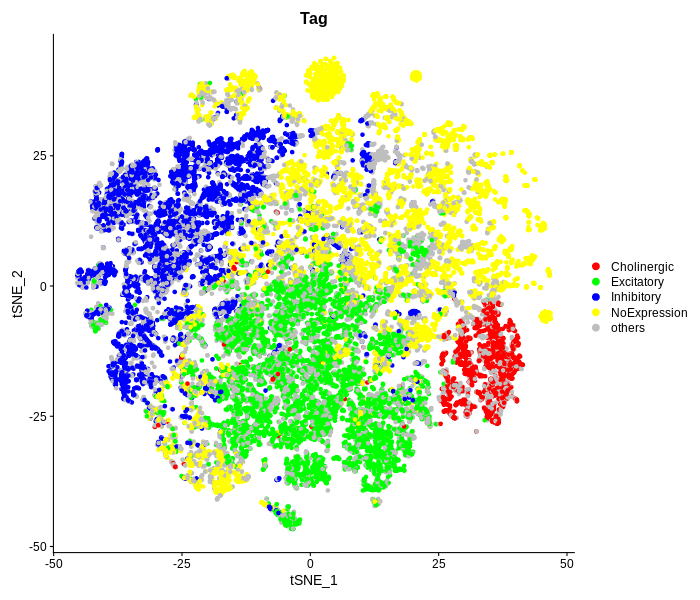

In [5]:
%%R -w 700 -h 600
p2 <- DimPlot(scRNA1, reduction = "tsne", group.by='Tag',pt.size=1.5,cols=c("red",'green','blue','yellow','grey'))
ggsave("figure/all.celltype.tsne.pdf")
p2



## 3.Filtered Excitatory Neuron cluster analysis 

In [ ]:
%%R
subRNA=subset(scRNA1,Tag=="Excitatory")
subRNA <- FindVariableFeatures(subRNA, selection.method = "vst",verbose=F)
hvg<-setdiff(VariableFeatures(subRNA),c("vGlut2",'vGat','Chat','Fos','Npas1'))
VariableFeatures(subRNA) <- hvg
subRNA <- ScaleData(subRNA, features = hvg,verbose=F,vars.to.regress="nCount_RNA")
subRNA <- RunPCA(subRNA, features = hvg,verbose=F)

VariableFeatures:

In [147]:
%%R
VariableFeatures(subRNA)

 [1] "Tac2"   "Pdyn"   "Nts"    "Gcg"    "Tac1"   "Th"     "Npy"    "Pomc"  
 [9] "vGlut3" "Lper"   "Dbh"    "Penk"   "Cart"   "Calb1"  "Calcr"  "Htr3a" 
[17] "Cck"    "Adcyap" "Drd1"  


### A) Seurat regular cluster analysis

In [148]:
%%R
subRNA <- FindNeighbors(subRNA, dims = 1:18,verbose=F)%>%
      FindClusters(resolution = 0.8,verbose=F)%>%
      RunUMAP(dims = 1:18,verbose=F)
subRNA=RunTSNE(subRNA,dims = 1:18,verbose=F,check_duplicates = FALSE)

#### re-order clusters based on their similarity

使用每个cluster gene 平均表达值 ，计算cluster之间的距离

In [150]:
%%R -o df3 -o info3
df3=as.data.frame(GetAssayData(subRNA,slot='count'))
info3=subRNA@meta.data
info3$seurat_clusters=as.character(info3$seurat_clusters)

In [151]:
res3=df3.loc[:,info3.index].T.groupby(info3.seurat_clusters).mean().fillna(0).T


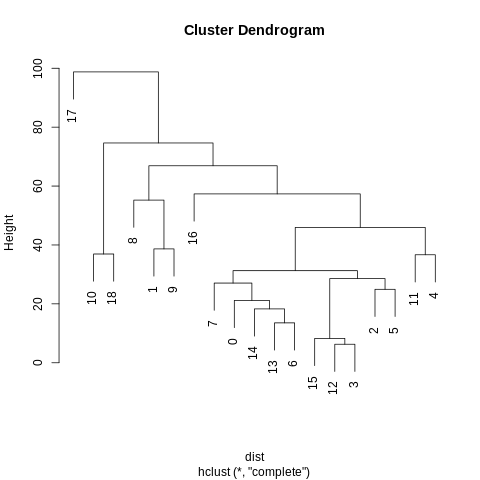

In [152]:
%%R -i res3
dist <- dist(t(res3) , diag=TRUE)
hc <- hclust(dist)
plot(hc)

In [153]:
%%R
new.cluster.ids <- c("9", "5", "14", "13", "17", "15", '12','8','4','6','2','16','18','11','10','18','7','1','3')
new.cluster.ids=as.integer(new.cluster.ids)
names(new.cluster.ids) <- levels(subRNA)

In [154]:
%%R
res32=res3[,names(new.cluster.ids)]
colnames(res32)=new.cluster.ids

re-order

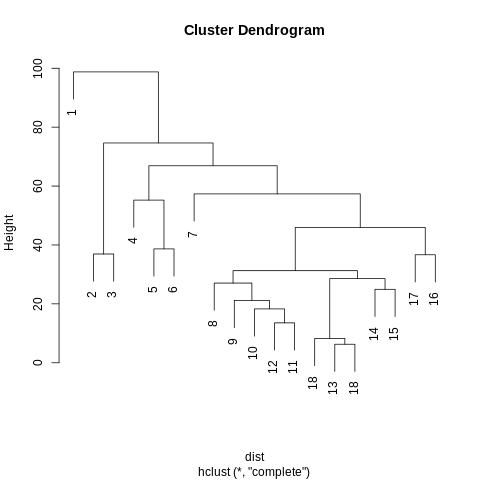

In [155]:
%%R
dist <- dist(t(res32) , diag=TRUE)
hc <- hclust(dist)
plot(hc)

In [156]:
%%R
subRNA=RenameIdents(subRNA,new.cluster.ids)
levels(subRNA)<-seq(1,18)
subRNA$new_seurat_clusters=Idents(subRNA)

In [157]:
%%R
saveRDS(subRNA,"subRNA0709.rds")

####  new_seurat_clusters

In [5]:
%%R

subRNA=readRDS("../subRNA0709.rds")

Saving 8.33 x 7.64 in image


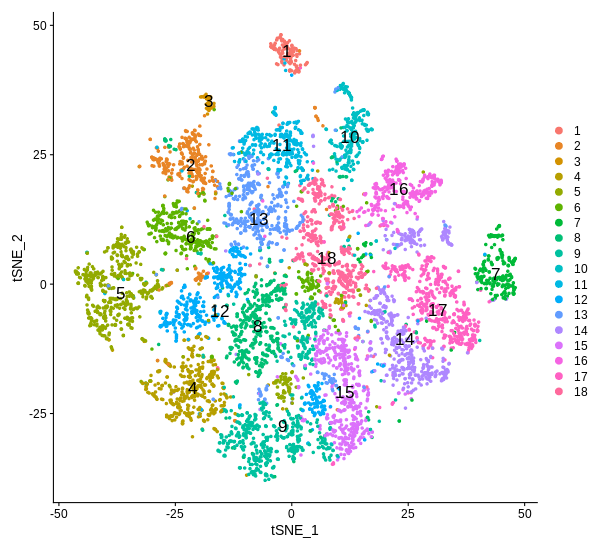

In [158]:
%%R -w 600 -h 550
p2<-DimPlot(subRNA, reduction = "tsne",label = T,label.size = 6,pt.size = 1)
ggsave("figure/subcluster.1.pdf")
p2

### 3) Plot: FeaturePlot showing the expression of vGlut2/Gat/Chat, regular scale vs log scale

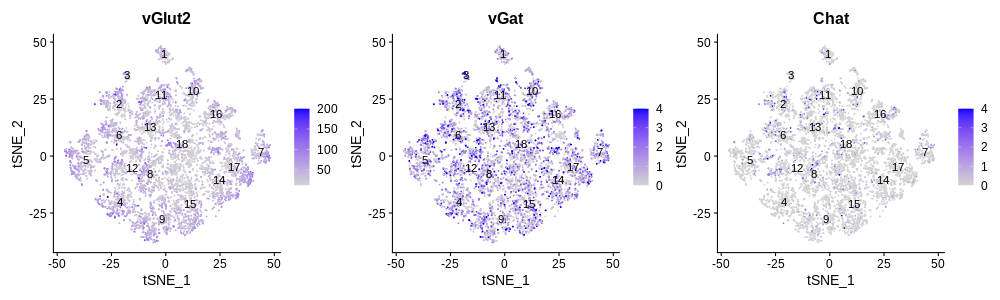

In [159]:
%%R -w 1000 -h 300
p=FeaturePlot(subRNA, features = c("vGlut2","vGat",'Chat'),label=T,ncol=3,reduction='tsne')
#ggsave("EXneuron.3marker.1.pdf")
p

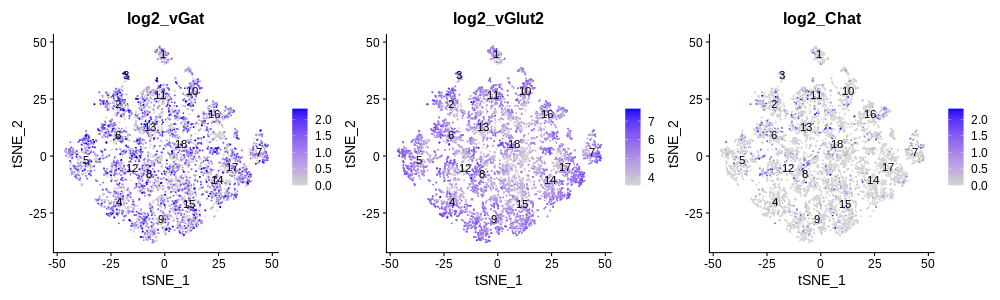

In [160]:
%%R -w 1000 -h 300
p=FeaturePlot(subRNA, features = c("log2_vGat",'log2_vGlut2','log2_Chat'),label=T,ncol=3,reduction='tsne')
#ggsave("allcell.feature.2.pdf")
p

### 4) Table: No. in each cluster, showing all data, each level (C1,2,3,4,5), or each batch (230329,230518

In [161]:
%%R
csv1=table(subRNA@meta.data[,c("new_seurat_clusters",'section')])
write.csv(csv1,"table1.csv",quote=F)
csv1

                   section
new_seurat_clusters  C1  C2  C3  C4  C5
                 1   64  53   5   0   0
                 2   61  37  43  77  99
                 3    2   4   3  12  25
                 4   24  40  66 100 187
                 5    3   6 115 230 222
                 6  144  40  91  49  67
                 7    8   8  30  99  83
                 8   70  88 159 107  44
                 9   88 156 229 107  79
                 10  57  73  46  47  12
                 11  55 116  44  44  39
                 12  37  67  22 230 120
                 13 116 129  97 106  45
                 14  16  78 187 137  85
                 15  66 107 115  97 100
                 16  51  89  87  40  45
                 17   6  24 115 176 172
                 18 103 102 124 104 103


http://bioinfo.cibr.ac.cn/download/CIBR-BL-RNAScope-20230615/table1.csv

In [162]:
%%R
csv2=table(subRNA@meta.data[,c("new_seurat_clusters",'batch')])
write.csv(csv2,"table2.csv",quote=F)
csv2

                   batch
new_seurat_clusters 230329 230518
                 1      72     50
                 2     154    163
                 3      26     20
                 4     321     96
                 5     363    213
                 6     175    216
                 7      92    136
                 8     255    213
                 9     214    445
                 10     50    185
                 11     98    200
                 12    351    125
                 13    206    287
                 14    221    282
                 15    275    210
                 16    150    162
                 17    283    210
                 18    301    235


http://bioinfo.cibr.ac.cn/download/CIBR-BL-RNAScope-20230615/table2.csv

### 5) VInPlot of all genes (using full gene list,make sure there's no duplication),log scale and non-log scale 

In [7]:
%%R
sort.genes=c("vGlut2",'vGat','Chat','Fos','Npas1',
            "Gcg",'Tac1','Tac2','Pdyn','Cart','Penk','Npy',
             'Cck','Adcyap','Nts',
             'Pomc',"Lper",'Htr3a','Drd1','Dbh',"vGlut3",'Calb1',
             "Calcr",'Th')

sort.genes

 [1] "vGlut2" "vGat"   "Chat"   "Fos"    "Npas1"  "Gcg"    "Tac1"   "Tac2"  
 [9] "Pdyn"   "Cart"   "Penk"   "Npy"    "Cck"    "Adcyap" "Nts"    "Pomc"  
[17] "Lper"   "Htr3a"  "Drd1"   "Dbh"    "vGlut3" "Calb1"  "Calcr"  "Th"    


In [8]:
%%R

plot.genes1=c("vGlut2",'vGat','Chat',
            "Gcg",'Tac1','Tac2','Pdyn','Cart','Penk','Npy',
             'Cck','Adcyap','Nts',
             'Pomc',"Lper",'Htr3a','Drd1','Dbh',"vGlut3",'Calb1',
             "Calcr",'Th')

plot.genes1

 [1] "vGlut2" "vGat"   "Chat"   "Gcg"    "Tac1"   "Tac2"   "Pdyn"   "Cart"  
 [9] "Penk"   "Npy"    "Cck"    "Adcyap" "Nts"    "Pomc"   "Lper"   "Htr3a" 
[17] "Drd1"   "Dbh"    "vGlut3" "Calb1"  "Calcr"  "Th"    


去掉'vGat','Chat',non-log scale

In [10]:
%%R
plot.genes2=c("vGlut2",
            "Gcg",'Tac1','Tac2','Pdyn','Cart','Penk','Npy',
             'Cck','Adcyap','Nts',
             'Pomc',"Lper",'Htr3a','Drd1','Dbh',"vGlut3",'Calb1',
             "Calcr",'Th')

plot.genes2

 [1] "vGlut2" "Gcg"    "Tac1"   "Tac2"   "Pdyn"   "Cart"   "Penk"   "Npy"   
 [9] "Cck"    "Adcyap" "Nts"    "Pomc"   "Lper"   "Htr3a"  "Drd1"   "Dbh"   
[17] "vGlut3" "Calb1"  "Calcr"  "Th"    


In [42]:
%%R
levels(Idents(subRNA))=c("18",'17','16','15','14','13','12','11','10','9','8','7','6','5','4','3','2','1')

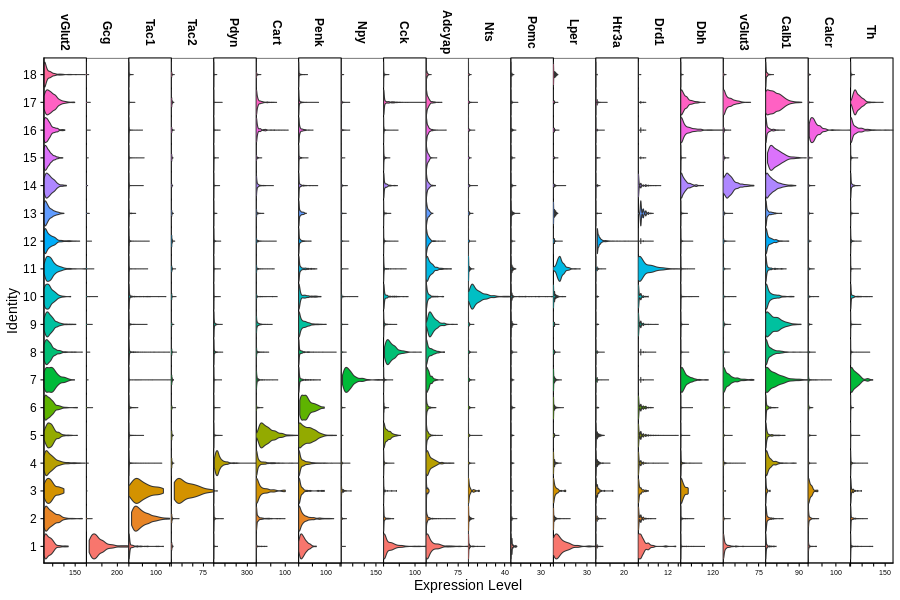

In [21]:
%%R -w 900 -h 600
subRNA=readRDS("subRNA0709.rds")
p=VlnPlot(subRNA, features = plot.genes2,pt.size=0,stack=T,flip = F,fill.by="ident")+
    theme(legend.position = "none",axis.text.x = element_text(angle = 0))
#ggsave("figure/EXneuron.stackvlnplot.markers.nonlog.pdf")
p

In [13]:
%%R
pbuild <- ggplot2::ggplot_build(p)
pdata <- pbuild$data[[1]]
pdata <-  pdata[order(pdata$group), ]


In [18]:
%%R
head(pdata[,c("fill",'group')]%>%distinct())

     fill group
1 #F8766D     1
2 #E88526     2
3 #D39200     3
4 #B79F00     4
5 #93AA00     5
6 #5EB300     6


In [8]:
%%R
subRNA2=subRNA
levels(Idents(subRNA2))=c("18",'17','16','15','14','13','12','11','10','9','8','7','6','5','4','3','2','1')

In [171]:
%%R -w 1200 -h 500
fig=VlnPlot(subRNA, features = "Fos",pt.size=0.5,log=F,split.by="batch")#+theme(axis.text.x = element_text(angle = 0, hjust=1))


In [172]:
%%R -o fig_result

fig_result=fig$data
fig_result$split=as.character(fig_result$split)
fig_result$ident=as.integer(as.character(fig_result$ident))

In [173]:
sns.set_style("whitegrid")
import matplotlib.pyplot as plt


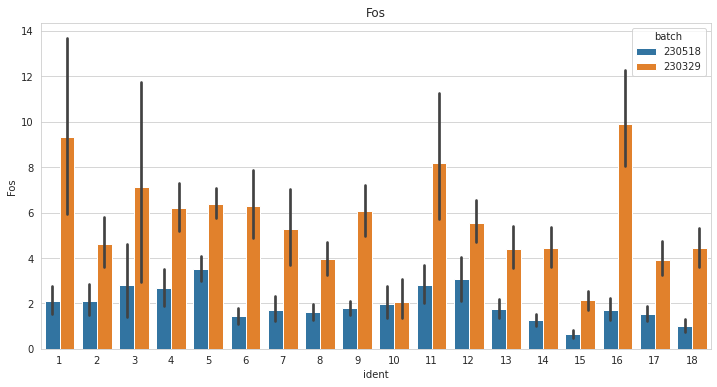

In [174]:
ax=sns.barplot(data=fig_result.rename(columns={"split":'batch'}).sort_values("ident"), x="ident", y="Fos",hue="batch")
ax.figure.set_size_inches(12,6)
ax.set_title("Fos")
plt.savefig('figure/Fox.barplot.pdf')


### 6) FeaturePlot of all genes (using full gene list,make sure there's no duplication),log scale and non-log scale 


non-scale

Saving 13.9 x 16.7 in image


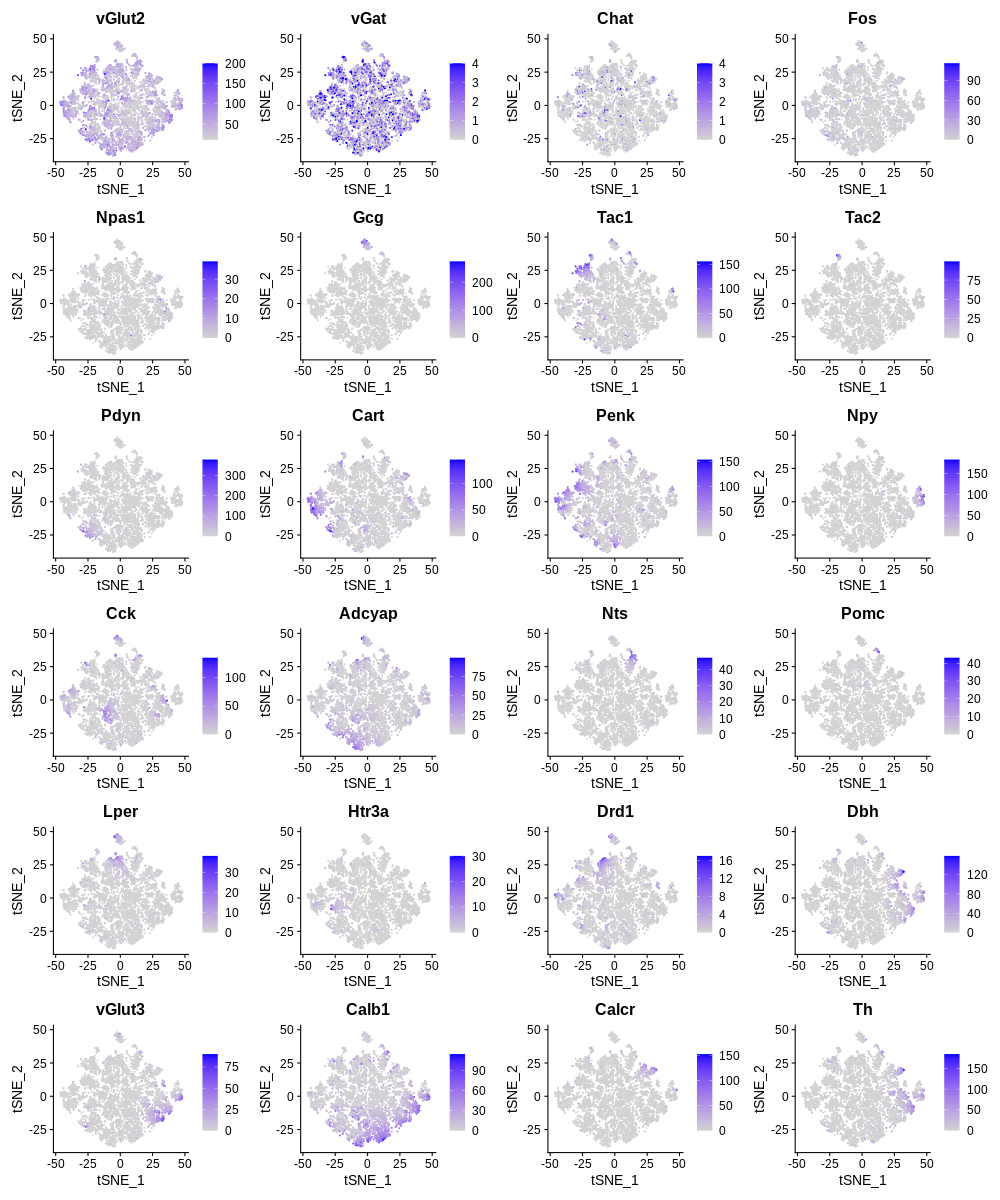

In [175]:
%%R -w 1000 -h 1200
plist=FeaturePlot(subRNA, features = sort.genes,label=F,ncol=4,reduction='tsne',keep.scale='feature',combine=T)
ggsave("figure/featureplot.tsne.non-log.pdf")
plist

In [176]:
%%R
subRNA2=subRNA
for (i in sort.genes){
    subRNA2@meta.data[,i]=log2(subRNA2[i,]$nCount_RNA+1)
}

由于seurat FeaturePlot 本身不支持log scale，我之前用的 NormalizeData 的log数据进行代替。刚想起来其还矫正了细胞数据量，与实际log数据有一点区别，遂重新计算了各个基因的log2数值，用于绘图。

Saving 13.9 x 16.7 in image


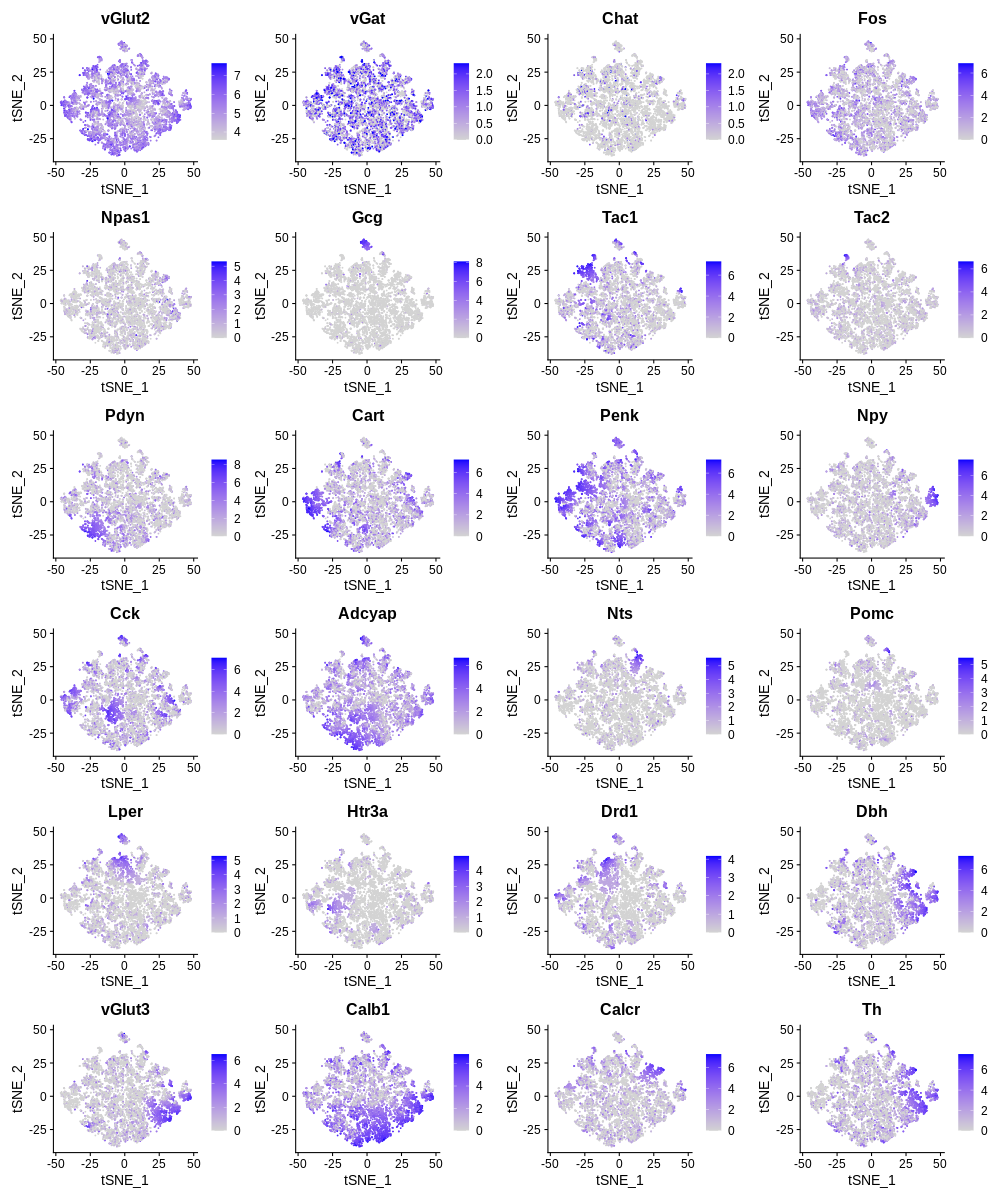

In [177]:
%%R -w 1000 -h 1200
plist=FeaturePlot(subRNA2, features = sort.genes,label=F,ncol=4,reduction='tsne',keep.scale='feature',combine=T)
ggsave("figure/featureplot.tsne.log.pdf")
plist

### 7) Heatmap of all genes


Saving 13.9 x 8.33 in image


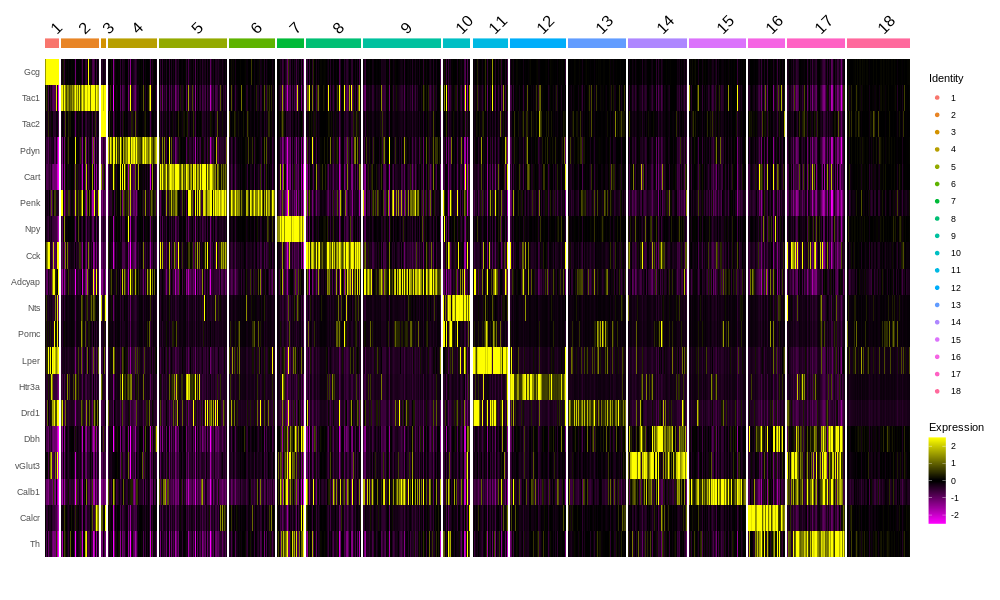

In [178]:
%%R -w 1000 -h 600

p=DoHeatmap(subRNA, features = sort.genes)
ggsave("figure/EXneuron.heatmap.markers.log.pdf")
p

In [86]:
%%R -o pdata
pdata=p$data
pdata$Feature=as.character(pdata$Feature)
pdata$Identity=as.character(pdata$Identity)

In [87]:
%%R -o sgene
sgene=sort.genes

In [9]:
sortgenes=["vGlut2",'vGat','Chat','Fos','Npas1',
            "Gcg",'Tac1','Tac2','Pdyn','Cart','Penk','Npy',
             'Cck','Adcyap','Nts',
             'Pomc',"Lper",'Htr3a','Drd1','Dbh',"vGlut3",'Calb1',
             "Calcr",'Th']

In [89]:
pdata2=pdata.set_index(['Feature','Cell']).Expression.unstack().dropna(axis=1)
sortgenes2=[i for i in sortgenes if i in pdata2.index.values]
pdata2=pdata2.loc[sortgenes2,]

### 8) DotPlot of all genes

In [14]:
%%R

subRNA

An object of class Seurat 
24 features across 7055 samples within 1 assay 
Active assay: RNA (24 features, 19 variable features)
 3 dimensional reductions calculated: pca, umap, tsne


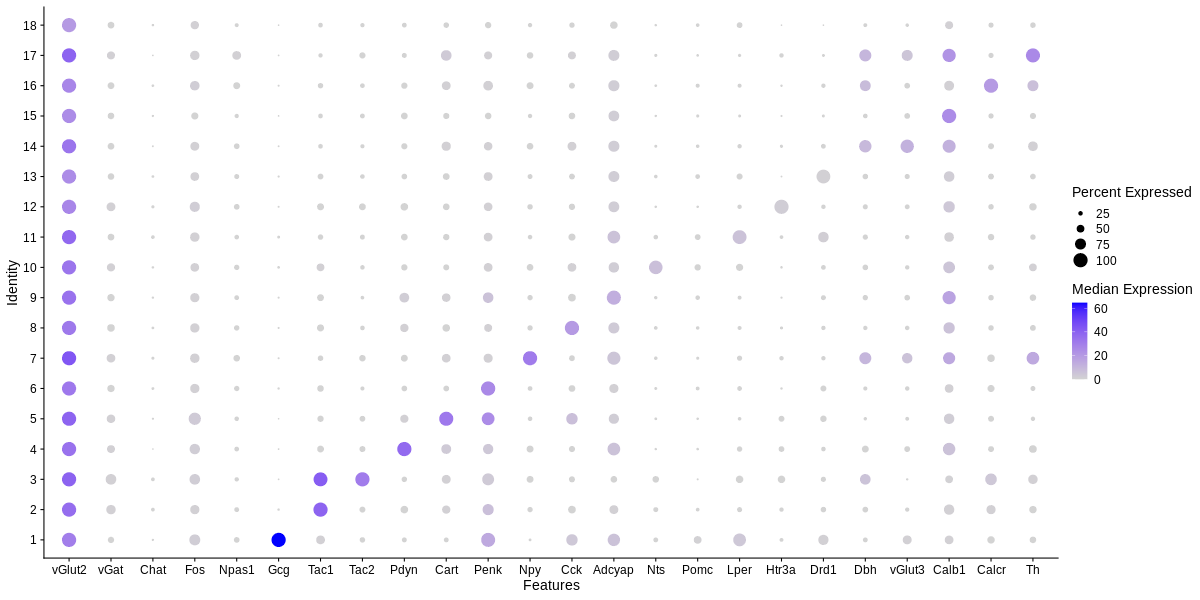

In [18]:
%%R -w 1200 -h 600
p=DotPlot2(subRNA, features =  sort.genes,scale=F)
#ggsave("EXneuron.dotplot.markers.log.pdf")
p

Saving 16.7 x 8.33 in image


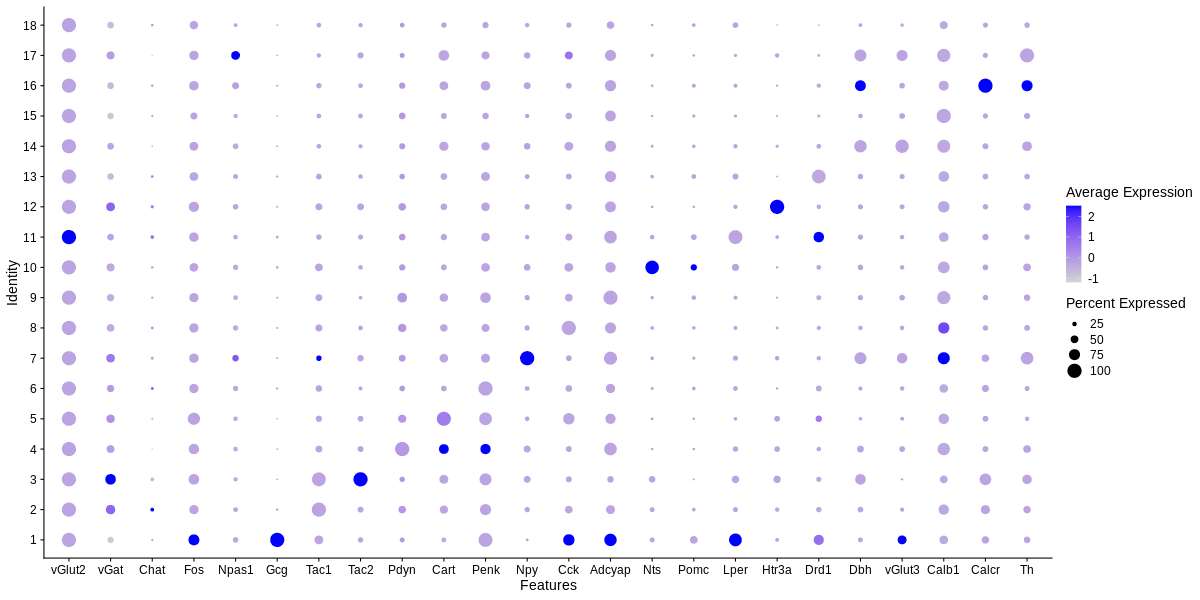

In [13]:
%%R -w 1200 -h 600
p=DotPlot(subRNA, features =  sort.genes,scale=T)
ggsave("EXneuron.dotplot.markers.log.pdf")
p

In [1]:
%%R

?Dotplot

UsageError: Cell magic `%%R` not found.


### 9) Export gene-cell matrix with extra info:

In [180]:
%%R
out=t(as.data.frame(GetAssayData(subRNA,slot='count')))
out=cbind(subRNA@meta.data[rownames(out),c("new_seurat_clusters","Cell.Position.X",'Cell.Position.Y','Tag')],out)

write.csv(out,"Excitatory.matrix.csv",quote=F)



http://bioinfo.cibr.ac.cn/download/CIBR-BL-RNAScope-20230615/Excitatory.matrix.csv


## RNAscope cluster  SnSeq cluster之间的correlation

In [181]:
%%R
scRNA1=readRDS("scRNA1.rds")

In [182]:
%%R
scRNA=readRDS("../reports/neurons.rds")
DefaultAssay(scRNA)<-"RNA"
scRNA$orig.ident="GSE166648"

In [183]:
%%R -o df1 -o info1
df1=as.data.frame(GetAssayData(scRNA,slot='count'))
info1=scRNA@meta.data
info1$seurat_clusters=as.character(info1$seurat_clusters)

In [184]:
%%R -o df2 -o info2
df2=as.data.frame(GetAssayData(scRNA1,slot='count'))
info2=scRNA1@meta.data
info2$seurat_clusters=as.character(info2$seurat_clusters)

In [185]:
import numpy as np

In [188]:
res2=df2.loc[:,info2.index].T.groupby(info2.seurat_clusters).mean().fillna(0).T
res2=res2.T.rename(columns={"vGlut2":'Slc17a6','vGat':"Slc32a1",'Cart':'Cartpt','vGlut3':"Slc17a8",
                           "pdyn":"Pdyn",'gcg':'Gcg','tac2':"Tac2",'tac1':"Tac1",'th':'Th','cck':"Cck",
                           "Lper":'Lepr','Adcyap':"Adcyap1"}).T


In [189]:
res1=df1.loc[res2.index].T.groupby(info1["neuronal.subtype"]).mean().fillna(0).T

In [190]:
data=pd.concat([res1,res2],axis=1)
cdata=data.corr().iloc[25:,:25]

In [191]:
rcParams['figure.figsize'] = 15,10
rcParams["legend.title_fontsize"]=10

In [192]:
%%R -w 1500 -h 1800
DefaultAssay(scRNA)<-'RNA'
scRNA$neuronal.subtype=as.factor(scRNA$neuronal.subtype)
levels(scRNA$neuronal.subtype)<-c('Chat1', 'Chat2', 'Chat3', 'GABA1', 'GABA2', 'GABA3', 'GABA4', 'GABA5',
       'GABA6', 'GABA7', 'Glu1',  'Glu2', 'Glu3', 'Glu4', 'Glu5', 'Glu6', 'Glu7', 'Glu8',
       'Glu9','Glu10', 'Glu11', 'Glu12', 'Glu13', 'Glu14',
       'Glu15')
Idents(scRNA)<-scRNA$neuronal.subtype
genelist2=c("Pdyn","Slc17a6","Gcg","Slc32a1","Tac2","Cartpt","Slc17a8","Tac1",
            "Th","Calb1","Drd1","Cck","Npy","Fos","Penk","Nts","Lper","Pomc","Chat",
            "Calcr","Npas1","Dbh","Adcyap1","Htr3a")



**兴奋性神经元的分类结果**

In [193]:
%%R -o df3 -o info3
df3=as.data.frame(GetAssayData(subRNA,slot='count'))
info3=subRNA@meta.data
info3$seurat_clusters=as.character(info3$new_seurat_clusters)

In [194]:
res3=df3.loc[:,info3.index].T.groupby(info3.seurat_clusters).mean().fillna(0).T
res3=res3.T.rename(columns={"vGlut2":'Slc17a6','vGat':"Slc32a1",'Gart':'Cartpt','vGlut3':"Slc17a8",
                           "pdyn":"Pdyn",'gcg':'Gcg','tac2':"Tac2",'tac1':"Tac1",'th':'Th','cck':"Cck",
                           "Lper":'Lepr','Adcyap':"Adcyap1"}).T

not used genes:'Slc17a6','Slc32a1','Chat','Fos','Npas1'

In [195]:
res1=res1.loc[:,['Glu1','Glu2', 'Glu3', 'Glu4', 'Glu5', 'Glu6', 'Glu7', 'Glu8',
       'Glu9','Glu10', 'Glu11', 'Glu12', 'Glu13', 'Glu14',
       'Glu15',]]

In [1]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [4]:

import matplotlib
print("matplotlib verion is {}".format(matplotlib.__version__))

matplotlib verion is 3.5.2


In [197]:
scaler = MinMaxScaler()
 
res3_scaled = scaler.fit_transform(res3.T.to_numpy())
res3_scaled = pd.DataFrame(res3_scaled.T, columns=res3.columns,index=res3.index.values)

In [198]:
res1_scaled = scaler.fit_transform(res1.T.to_numpy())
res1_scaled = pd.DataFrame(res1_scaled.T, columns=res1.columns,index=res1.index.values)

In [199]:
sdata=pd.concat([res1_scaled,res3_scaled],axis=1)
sdata=sdata[sdata.index.isin(['Slc17a6','Slc32a1','Chat','Fos','Npas1'])==False]


In [200]:

csdata=sdata.corr().iloc[15:,:15]
csdata.index=csdata.index.astype(int)
csdata=csdata.sort_index()

In [201]:
rcParams['figure.figsize'] = 15,10
rcParams["legend.title_fontsize"]=10

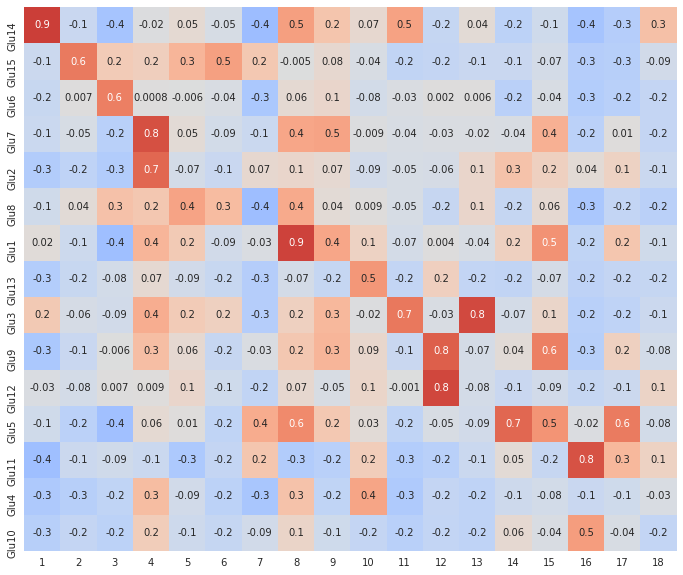

In [205]:
pinput=csdata.loc[:,['Glu14','Glu15','Glu6', 'Glu7', 'Glu2', 'Glu8', 'Glu1', 'Glu13','Glu3','Glu9','Glu12','Glu5', 'Glu11', 'Glu4', 'Glu10']].T
with sns.axes_style("darkgrid"):
    sns.heatmap(pinput,cbar=False,annot=True,fmt='.1g',cmap="coolwarm",vmax=1,vmin=-1,square=True)
    plt.savefig('figure/scRNA.RNAscope.corr.pdf')

In [203]:
pinput.to_csv("figure/scRNA.RNAscope.corr.csv")